In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# Setup environment
!apt-get -qq install xxd


Selecting previously unselected package xxd.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.8_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.8) ...
Setting up xxd (2:8.0.1453-1ubuntu1.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


##Lectura del dataset

El dataset se entrega en archivos con extension .csv para cada clase

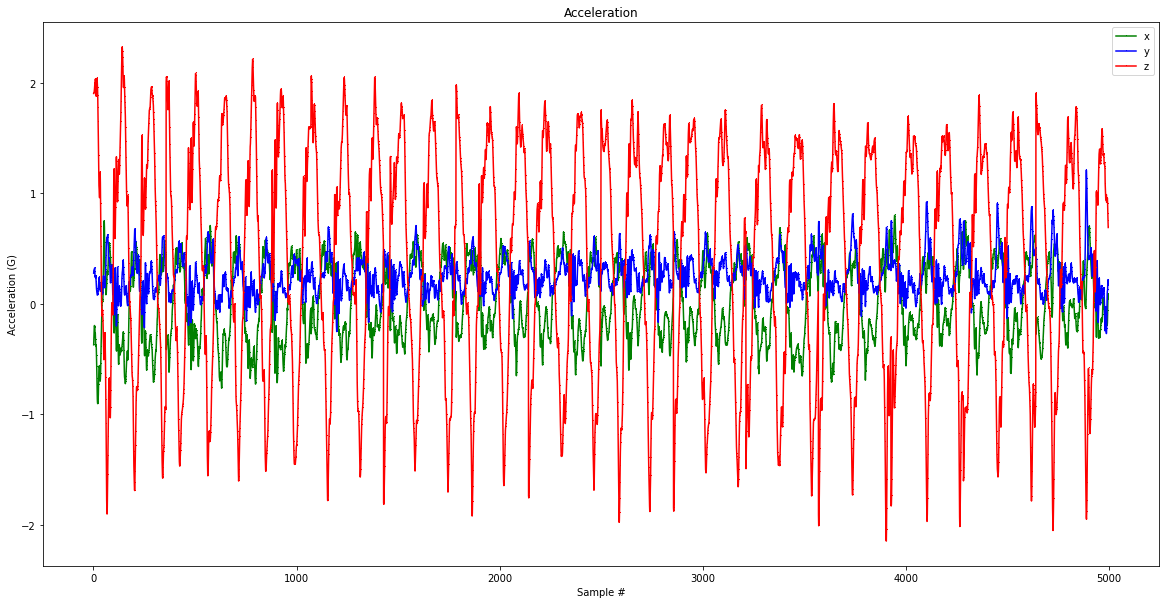

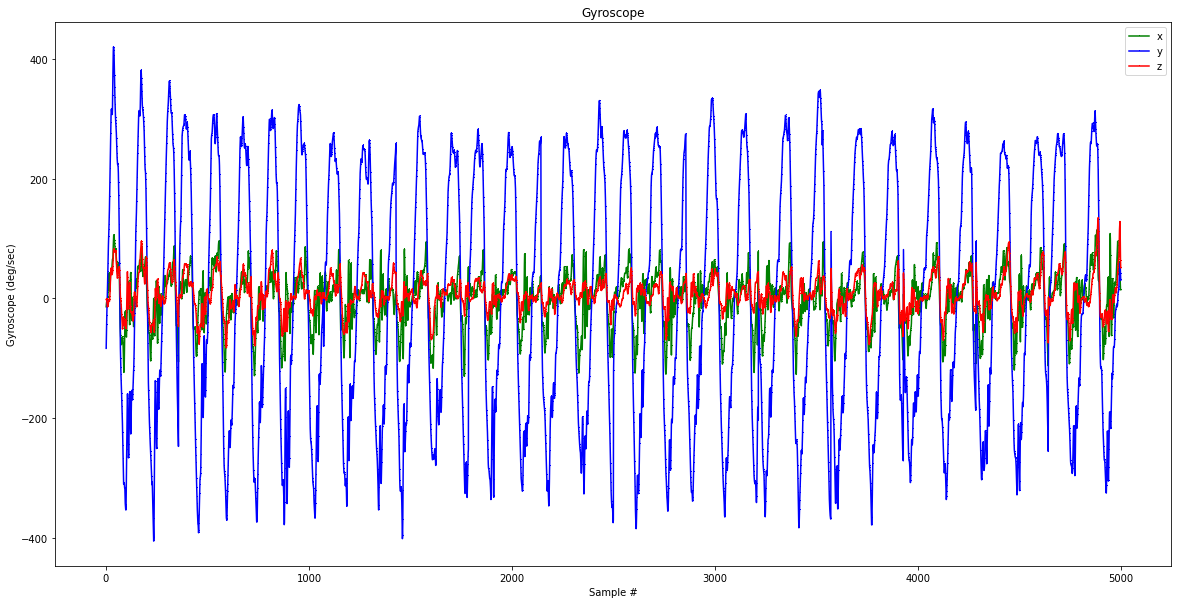

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

filename = "biceps2.csv"

df = pd.read_csv("/content/gdrive/MyDrive/Arduino/" + filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()


El dataset trae 42 muestras de 3 segundos sin embargo para reducir el tamaño del modelo a continuacion se toman muestras de 1 segundo para aumentar los datos de entrenamiento y reducir el tiempo en el que se deben tomar muestras en el arduino.

al hacer esta division se obtienen 100 muestras de 1 segundo para entrenar, 33 para validar y 35 para test

In [9]:

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "biceps2",
    "branquial2",
    "elevacion2",
    "levantamiento2"
]

SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv("/content/gdrive/MyDrive/Arduino/" + gesture + ".csv")
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.8.2

Processing index 0 for gesture 'biceps2'.
	There are 42 recordings of the biceps2 gesture.
Processing index 1 for gesture 'branquial2'.
	There are 42 recordings of the branquial2 gesture.
Processing index 2 for gesture 'elevacion2'.
	There are 42 recordings of the elevacion2 gesture.
Processing index 3 for gesture 'levantamiento2'.
	There are 42 recordings of the levantamiento2 gesture.
Data set parsing and preparation complete.


In [10]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Construccion y entrenamiento del modeolo



In [11]:
# build the model and train it
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Dense(40, activation='relu')) # relu is used for performance
model4.add(tf.keras.layers.Dense(10, activation='relu'))
model4.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model4.compile(optimizer="rmsprop", loss="mae", metrics=['mae',"accuracy"])
history = model4.fit(inputs_train, outputs_train, epochs=300, batch_size=5, validation_data=(inputs_validate, outputs_validate))



Epoch 1/300
20/20 [==============================] - 1s 11ms/step - loss: 0.3753 - mae: 0.3753 - accuracy: 0.2300 - val_loss: 0.3781 - val_mae: 0.3781 - val_accuracy: 0.2571
Epoch 2/300
20/20 [==============================] - 0s 3ms/step - loss: 0.3724 - mae: 0.3724 - accuracy: 0.2300 - val_loss: 0.3785 - val_mae: 0.3785 - val_accuracy: 0.2571
Epoch 3/300
20/20 [==============================] - 0s 4ms/step - loss: 0.3723 - mae: 0.3723 - accuracy: 0.2300 - val_loss: 0.3787 - val_mae: 0.3787 - val_accuracy: 0.2571
Epoch 4/300
20/20 [==============================] - 0s 3ms/step - loss: 0.3717 - mae: 0.3717 - accuracy: 0.2300 - val_loss: 0.3790 - val_mae: 0.3790 - val_accuracy: 0.2571
Epoch 5/300
20/20 [==============================] - 0s 4ms/step - loss: 0.3712 - mae: 0.3712 - accuracy: 0.2300 - val_loss: 0.3793 - val_mae: 0.3793 - val_accuracy: 0.2571
Epoch 6/300
20/20 [==============================] - 0s 4ms/step - loss: 0.3710 - mae: 0.3710 - accuracy: 0.2300 - val_loss: 0.3797 - 

In [12]:
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (5, 40)                   28600     
                                                                 
 dense_1 (Dense)             (5, 10)                   410       
                                                                 
 dense_2 (Dense)             (5, 4)                    44        
                                                                 
Total params: 29,054
Trainable params: 29,054
Non-trainable params: 0
_________________________________________________________________


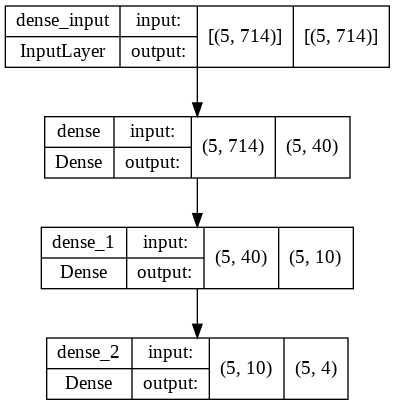

In [15]:
from tensorflow import keras
keras.utils.plot_model(model4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Graph the loss

Graph the loss to see when the model stops improving.

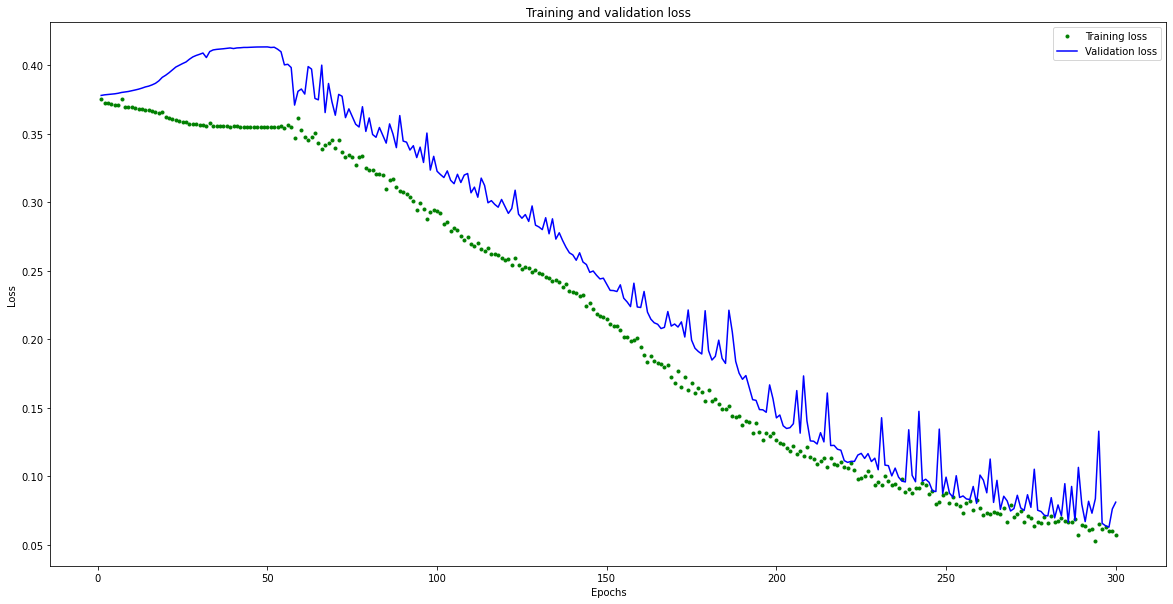

[20.0, 10.0]


In [16]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

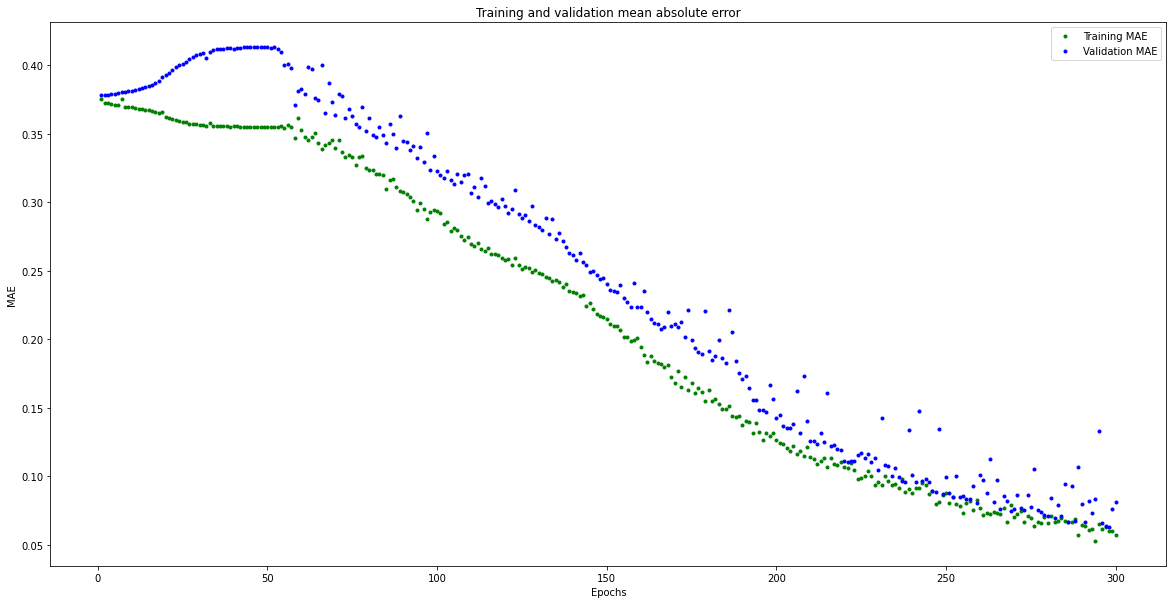

In [18]:
# graph of mean absolute error
SKIP=0
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### Prueba con datos de Test



predictions =
 [[0.002 0.351 0.    0.647]
 [0.    0.976 0.    0.024]
 [0.    0.986 0.    0.014]
 [0.878 0.    0.    0.122]
 [0.2   0.    0.8   0.   ]
 [0.968 0.    0.002 0.03 ]
 [0.    0.947 0.    0.053]
 [0.    0.979 0.    0.021]
 [0.    0.979 0.    0.021]
 [0.    0.965 0.    0.035]
 [0.196 0.003 0.    0.8  ]
 [0.    0.918 0.    0.082]
 [0.    0.977 0.    0.023]
 [0.    0.846 0.    0.154]
 [0.067 0.    0.933 0.   ]
 [0.    0.85  0.    0.15 ]
 [0.059 0.02  0.    0.921]
 [0.393 0.001 0.    0.606]
 [0.018 0.    0.982 0.   ]
 [0.904 0.    0.    0.096]
 [0.328 0.001 0.    0.671]
 [0.    0.899 0.    0.101]
 [0.95  0.    0.001 0.049]
 [0.009 0.114 0.    0.877]
 [0.045 0.    0.955 0.   ]
 [0.883 0.    0.    0.117]
 [0.037 0.    0.963 0.   ]
 [0.    0.988 0.    0.012]
 [0.05  0.02  0.    0.93 ]
 [0.    0.628 0.    0.372]
 [0.87  0.    0.    0.13 ]
 [0.936 0.    0.    0.063]
 [0.796 0.    0.    0.204]]
actual =
 [[0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  if sys.path[0] == '':


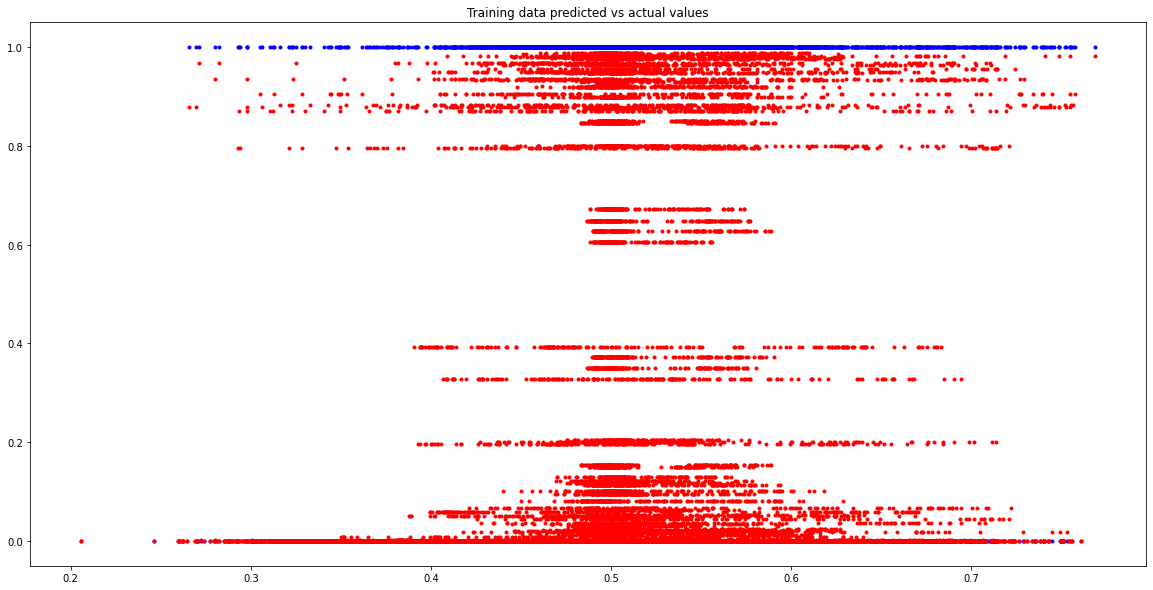

In [19]:
# use the model to predict the test inputs
predictions = model4.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()

MATRIZ DE CONFUSION

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.77      1.00      0.87        10
           2       1.00      1.00      1.00         5
           3       1.00      0.64      0.78        11

    accuracy                           0.88        33
   macro avg       0.91      0.91      0.90        33
weighted avg       0.90      0.88      0.87        33

[[ 7  0  0  0]
 [ 0 10  0  0]
 [ 0  0  5  0]
 [ 1  3  0  7]]


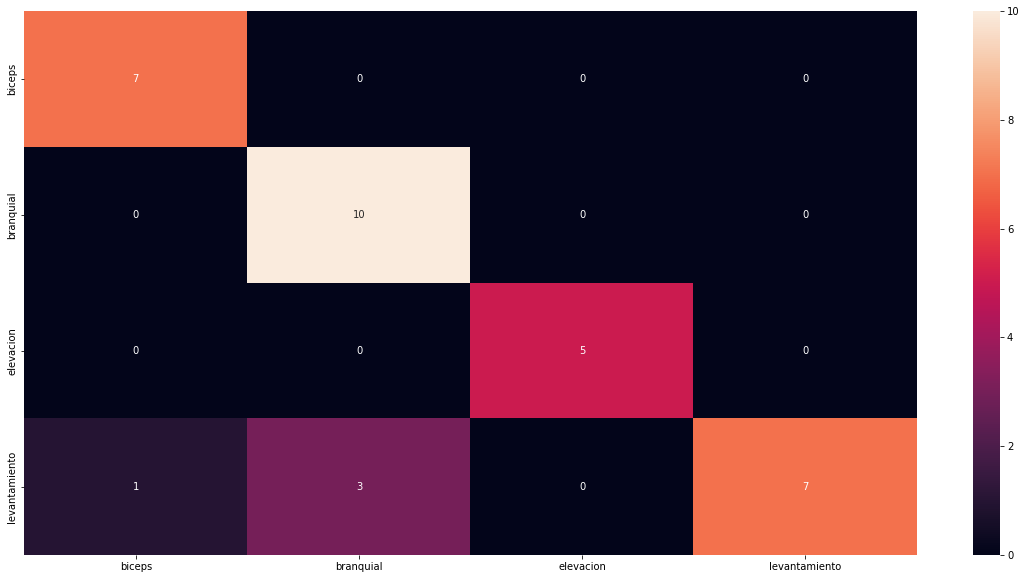

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

ypredic=predictions

y_test_class = np.argmax(outputs_test,axis=1) 
y_pred_class = np.argmax(ypredic,axis=1) 

#Accuracy of the predicted values
print(classification_report(y_test_class, y_pred_class)) # Precision , Recall, F1-Score & Support
cm = confusion_matrix(y_test_class, y_pred_class)
print(cm)
# visualize the confusion matrix in a heat map
df_cm = pd.DataFrame(cm)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d", xticklabels=['biceps','branquial','elevacion','levantamiento'],yticklabels=['biceps','branquial','elevacion','levantamiento'])

##Convirtiendo el modelo a tensorflow lite

In [21]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model4)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

INFO:tensorflow:Assets written to: /tmp/tmp6tkp4_ud/assets


Model is 118040 bytes


In [23]:
!echo "const unsigned char model[] = {" > /content/model2.h
!cat gesture_model.tflite | xxd -i      >> /content/model2.h
!echo "};"                              >> /content/model2.h

import os
model_h_size = os.path.getsize("model2.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 727,948 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
